# Medición de diámetros a partir de una imagen patrón

In [ ]:
%pip install opencv-python
%pip install numba
%pip install tk
%pip install ipympl

In [1]:
from functions import *     # Funciones definidas en functions.py (Para VS Code agregar dir. en carpeta AppData, settings.json)
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from metas_unclib import *  # Requiere la librería de C# METAS UncLib en segundo plano
use_linprop()
from tkinter import Tk  
from tkinter.filedialog import askopenfilename

## Preparación de archivos

In [2]:
DIR = "C:\\Users\\Admin\\Documents\\SEM Lineas de Aire\\Mediciones" # Directorio base para varias imágenes

ENDEREZAR = True   # True para enderezar las imágenes
CANNY = True    # Define el método utilizado para la detección de bordes. Canny_Edges si True, Thresholding si False.

Ventana para seleccionar archivos

In [3]:
root = Tk()
root.withdraw()
root.call('wm', 'attributes', '.', '-topmost', True)

path_patron = askopenfilename(filetypes=[("Archivo TIF", "*.tif"), ("Archivo BMP", "*.bmp"), ("All files", "*.*")], title='Seleccione Patrón', initialdir=DIR)
path_dut = askopenfilename(filetypes=[("Archivo TIF", "*.tif"), ("Archivo BMP", "*.bmp"), ("All files", "*.*")], title='Seleccione DUT', initialdir=DIR)

if path_patron.endswith('.ufloat'): # Carga valores ya calculados
    peso_pixel = ustorage.load_binary_file(path_patron)
    calcular_patron = False
else:
    calcular_patron = True

Utiliza uno de los métodos de deteccion y optimiza el ángulo de rotación (si ENDEREZAR = True). Siempre verificar la imagen de salida!

Comprobar las imágenes de entrada

In [4]:
SCALE = 15  # Factor de escala para visualización

if calcular_patron:
    patron = cv2.imread(path_patron, cv2.IMREAD_UNCHANGED)
    if patron.dtype == 'uint16':
        patron = (patron/256).astype('uint8')
    patron = delete_bottom(patron, 320)
    # patron = delete_left(patron, 10)
    # patron = delete_right(patron, 10)
    show_image(patron, SCALE)

dut = cv2.imread(path_dut, cv2.IMREAD_UNCHANGED)
if dut.dtype == 'uint16':
    dut = (dut/256).astype('uint8')
dut = delete_bottom(dut, 320)
dut = delete_left(dut, 600)
# dut = delete_right(dut, 250)
show_image(dut, SCALE)

## Definir los valores de umbral

In [8]:
if CANNY:
    # Otros parámetros a definir (ver función Canny_Edges)
    bs = 3 # blur_size
    l2g = False #L2gradient

    if calcular_patron:
        dt1 = DefineThreshold(patron, Canny_Edges, two_params=True, scale=SCALE)
        th1_pat, th2_pat = dt1.get_th(blur_size = bs, L2gradient = l2g)

    dt1 = DefineThreshold(dut, Canny_Edges, two_params=True, scale=SCALE)
    th1_dut, th2_dut = dt1.get_th(blur_size = bs, L2gradient = l2g)
else:
    if calcular_patron:
        dt1 = DefineThreshold(patron, Thresholding, two_params=False, scale=SCALE)
        th1_pat, th2_pat = dt1.get_th()

    dt1 = DefineThreshold(dut, Thresholding, two_params=False, scale=SCALE)
    th1_dut, th2_dut = dt1.get_th()

In [ ]:
from matplotlib.widgets import Slider
%matplotlib widget

if CANNY:
    edges1 = Canny_Edges(dut, th1_dut, th2_dut, l2g, bs)    #Deteccion de bordes
    if calcular_patron:
        edges2 = Canny_Edges(patron, th1_pat, th2_pat, l2g, bs)    #Deteccion de bordes
else:
    edges1 = Thresholding(dut, th1_dut, th2_dut)
    if calcular_patron:
        edges2 = Thresholding(patron, th1_pat, th2_pat)

xmin = 400
xmax = 475

dut_blur = cv2.GaussianBlur(dut, (3, 3), sigmaX=0, sigmaY=0)  # Blurea la imagen

fig, ax = plt.subplots(figsize=(10,6))
line, = ax.plot(dut[0,xmin:xmax,1])
line2, = ax.plot(dut_blur[0,xmin:xmax,1])
edge = ax.axvline(first_pixel(edges1[0])-xmin, c='r')
fig.subplots_adjust(bottom=0.25)
axfreq = fig.add_axes([0.25, 0.1, 0.65, 0.03])
slider = Slider(
    ax=axfreq,
    valstep = 1,
    label='Row',
    valmin=0,
    valmax=dut.shape[0]-1,
    valinit=0,
)

def update(val):
    # Actualizar la posición de la línea vertical
    edge.set_xdata([first_pixel(edges1[val]) - xmin])
    
    # Actualizar la línea del gráfico principal
    line.set_ydata(dut[val, xmin:xmax, 1])
    line2.set_ydata(dut_blur[val, xmin:xmax, 1])
    
    # Redibujar la figura
    fig.canvas.draw_idle()

slider.on_changed(update)
plt.show()

Guardar Imagenes

In [15]:
save_img(edges1, path_dut, "bordes")
if calcular_patron:
    save_img(edges2, path_patron, "bordes")

## Enderezamiento y medición

Posibles parámetros para elegir el angulo de rotación: 
- Tomar las distancias globalmente, cuando su media o su desvío sean mínimos.
- Agrupar los primeros y últimos pixeles, cuando el desvío de cada grupo sea menor.

Se encontraron mejores resultados con el segundo método, que es el que se incluye.

### PATRÓN

Desvío primer pixel (px)
Mejor angulo medido: 0.526°
Mejor angulo ajustado: 0.308°. Score=0.83

Desvío último pixel (px)
Mejor angulo medido: 1.579°
Mejor angulo ajustado: 2.0°. Score=0.71

Ajuste entre ambos lados: 1.089 °


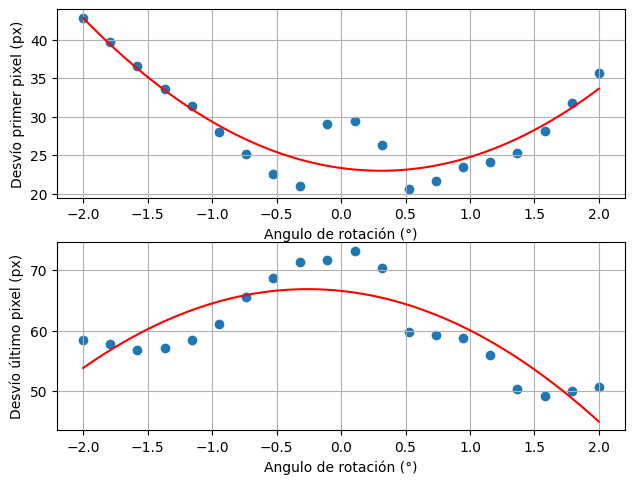

In [9]:
# Generar vector de grados, si el mínimo de la curva se encuentra
# muy desplazado, volver a generarlo teniendo eso en cuenta.
grados = np.linspace(-2, 2, 20) 

if calcular_patron:
    if ENDEREZAR:
        if CANNY:
            angulo_elegido = align(patron, grados, Canny_Edges, th1=th1_pat, th2=th2_pat, L2gradient=l2g, blur_size=bs)
        else:
            angulo_elegido = align(patron, grados, Thresholding, thresh=th1_pat, max_val=th2_pat)
    else:
        angulo_elegido = 0

Medición final con ángulo elegido

In [10]:
# Correccion a mano
angulo_elegido = 0.2

Media inicial: 5619.543579671004
Moda: 5603
Media final: 5606.360294117647



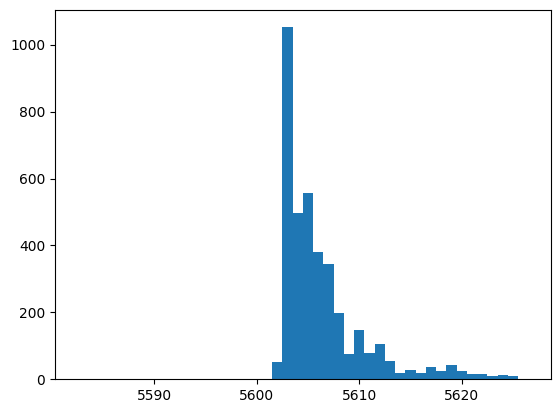

3808 filas con media 5606.360294117647 (0.06955994484161712) px



In [11]:
if calcular_patron:
    img = rotate_and_cut(patron, angulo_elegido)  # Rota la imagen g grados según lo ajustado
    if CANNY:
        edges = Canny_Edges(img, th1_pat, th2_pat)    #Deteccion de bordes
    else:
        edges = Thresholding(img, th1_pat, th2_pat)
    show_image(edges, SCALE)
    # cv2.imwrite(DIR + "Pat_Edges.bmp", edges)
    diams1 = direct_distance(edges, outlier_percent=1, plot=True)   #Mide distancias entre bordes
    mean_patron, u_patron = measure_distribution(diams1)   #Guarda las medias y desvios

### DUT

Desvío primer pixel (px)
Mejor angulo medido: 0.474°
Mejor angulo ajustado: -0.763°. Score=0.346

Desvío último pixel (px)
Mejor angulo medido: -0.789°
Mejor angulo ajustado: -0.466°. Score=0.544

Ajuste entre ambos lados: -0.581 °


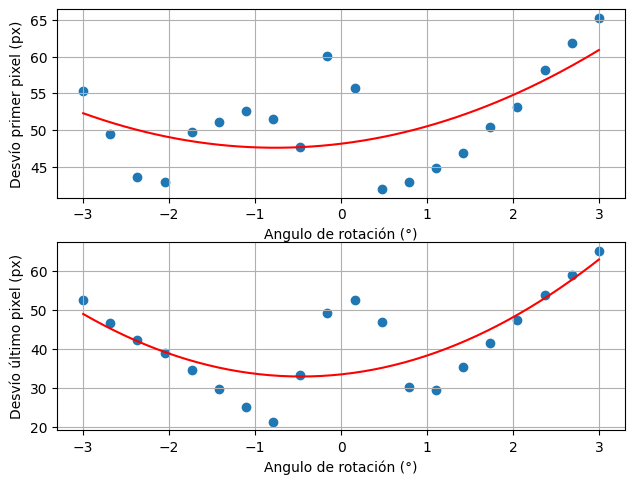

In [15]:
# Generar vector de grados, si el mínimo de la curva se encuentra
# muy desplazado, volver a generarlo teniendo eso en cuenta.
grados = np.linspace(-3, 3, 20) 

if ENDEREZAR:
    if CANNY:
        angulo_elegido = align(dut, grados, Canny_Edges, th1=th1_dut, th2=th2_dut, L2gradient=l2g, blur_size=bs)
    else:
        angulo_elegido = align(dut, grados, Thresholding, thresh=th1_dut, max_val=th2_dut)
else:
    angulo_elegido = 0

In [48]:
#Ajuste a mano
# angulo_elegido = -0.5

Medición final con ángulo elegido

Media inicial: 4650.827184946769
Moda: 4644
Media final: 4642.857980622131



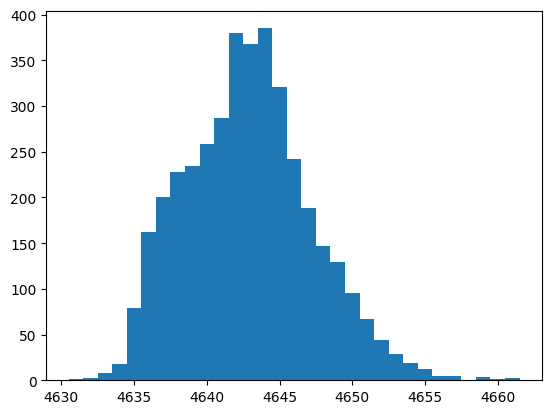

3922 filas con media 4642.857980622131 (0.06964230909333298) px



In [16]:
img = rotate_and_cut(dut, angulo_elegido)  # Rota la imagen g grados según lo ajustado
if CANNY:
    edges = Canny_Edges(img, th1_dut, th2_dut, l2g, bs)    #Deteccion de bordes
else:
    edges = Thresholding(img, th1_dut, th2_dut)
# cv2.imwrite(DIR + "DUT_Edges.bmp", edges)
show_image(edges, SCALE)
diams1 = direct_distance(edges, outlier_percent=1, plot=True)   #Mide distancias entre bordes
mean_dut, u_dut = measure_distribution(diams1)   #Guarda las medias y desvios

## Cálculo

In [17]:
# ---------------- Parámetros -----------------

DIAMETRO_PATRON = 1500 # diámetro medido del patrón (micrómetros)
INCERTIDUMBRE_PATRON = 0.023 # incert. patrón

diam_patron = ufloat(DIAMETRO_PATRON, INCERTIDUMBRE_PATRON, id='1', desc="Magnitud del Patrón")
media_patron = ufloat(mean_patron, u_patron, id='2', desc="Media de pixeles del patrón")

peso_pixel = diam_patron/media_patron

In [18]:
media_dut = ufloat(mean_dut, u_dut, id='3', desc="Media de pixeles del DUT")
result = peso_pixel * media_dut

print("Peso de 1 pixel:", peso_pixel, "um")
print(f"El diametro resultante es de {result} micrometros")

Peso de 1 pixel: 0.2675532647400209 ± 7.828625761163865e-07 um
El diametro resultante es de 1242.2118104397118 ± 0.02226774692120725 micrometros


## Guardado

In [27]:
ustorage.save_binary_file(peso_pixel, DIR + "\\peso_pixel_1_5.ufloat")
ustorage.save_binary_file(result, DIR + "\\diametro_linea_1_27.ufloat")